In [ ]:
!git clone https://github.com/YilinLiu97/CS790.git
!git clone https://github.com/MLI-lab/ConvDecoder.git
!pip install x-transformers
from ConvDecoder.demo_helper.helpers import *

Cloning into 'CS790'...
remote: Enumerating objects: 387, done.
remote: Counting objects: 100% (387/387), done.
remote: Compressing objects: 100% (341/341), done.
remote: Total 387 (delta 41), reused 383 (delta 40), pack-reused 0
Receiving objects: 100% (387/387), 199.17 MiB | 20.96 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Checking out files: 100% (220/220), done.
Cloning into 'ConvDecoder'...
remote: Enumerating objects: 689, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 689 (delta 126), reused 5 (delta 2), pack-reused 471
Receiving objects: 100% (689/689), 94.11 MiB | 29.50 MiB/s, done.
Resolving deltas: 100% (325/325), done.
  Created wheel for entmax: filename=entmax-1.0-py3-none-any.whl size=11015 sha256=4938523803d3cc644dbbb014c2f60067988852dae733ce2f7e0657fb92ab74ac
  Stored in directory: /root/.cache/pip/wheels/f7/e8/0d/acc29c2f66e69a1f42483347fa8545c293dec12325ee161716
Successfully built entmax


In [ ]:
!git clone https://github.com/DmitryUlyanov/deep-image-prior.git

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 24.28 MiB | 19.23 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [ ]:
!cd CS790/language_transformer

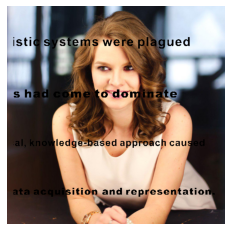

In [14]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from PIL import Image
from DIP.models import *

import torch
import torch.optim

from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from DIP.utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor


# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
model_type = 'CNN'
task_type = 'inpainting'
fname = 'DIP/data/denoising/F16_GT.png' if task_type == 'denoising' else 'DIP/data/inpainting/kate.png'
mask_path = 'DIP/data/inpainting/kate_mask.png'

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

if fname == 'DIP/data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    
    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np
    
    if PLOT:
        plot_image_grid([img_np], 4, 5);
        
elif fname == 'DIP/data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    imsize = -1
    dim_div_by = 64 

    img_pil, img_np = get_image(fname, imsize)
    img_mask_pil, img_mask_np = get_image(mask_path, imsize)

    img_mask_pil = crop_image(img_mask_pil, dim_div_by)
    img_pil      = crop_image(img_pil,      dim_div_by)

    img_np      = pil_to_np(img_pil)
    img_mask_np = pil_to_np(img_mask_pil)

# Store images
if task_type == 'denoising':
  plt.imshow(img_np.transpose(1,2,0))
  plt.axis('off')
  plt.savefig('img_dir/GT.png')

  plt.imshow(img_noisy_np.transpose(1,2,0))
  plt.axis('off')
  plt.savefig('img_dir/noisy_target.png')
else:
  plt.imshow(img_np.transpose(1,2,0))
  plt.axis('off')
  plt.savefig('CNN_inpainting_img_dir/noisy_img.png')

  plt.imshow(np.squeeze(img_mask_np))
  plt.axis('off')
  plt.savefig('CNN_inpainting_img_dir/mask.png')
 
  plt.imshow((img_mask_np * img_np).transpose(1,2,0))
  plt.axis('off')
  plt.savefig('CNN_inpainting_img_dir/masked_img.png')
  

### A Decoder-like Transformer Generator

In [15]:
import itertools
import torch
import torch.nn as nn
from x_transformers import ViTransformerWrapper, TransformerWrapper, Encoder, Decoder
import math
import torch.nn.functional as F

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention


class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.contiguous().view(batch_size, seq_length, -1)#reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

class TransDecoder(nn.Module):

  def __init__(self, input_dim, num_heads, output_dim, in_size, out_size, num_layers = 5, dropout=0.0):
    super().__init__()
 
    ### compute up-sampling factor from one layer to another
    scale_x,scale_y = (out_size[0]/in_size[0])**(1./(num_layers-1)), (out_size[1]/in_size[1])**(1./(num_layers-1))
    out_size = out_size[0] * out_size[1]
    self.hidden_size = [(int(np.ceil(scale_x**n * in_size[0]))*
                        int(np.ceil(scale_y**n * in_size[1]))) for n in range(1, (num_layers-1))] + [out_size]
    
    self.layer1 = MultiheadAttention(input_dim, input_dim, num_heads)
    self.norm1 = nn.LayerNorm(input_dim)
    self.layer2 = MultiheadAttention(input_dim, input_dim, num_heads)
    self.norm2 = nn.LayerNorm(input_dim)
    self.layer3 = MultiheadAttention(input_dim, input_dim, num_heads)
    self.norm3 = nn.LayerNorm(input_dim)
    self.layer4 = MultiheadAttention(input_dim, input_dim, num_heads)
    self.norm4 = nn.LayerNorm(input_dim)

    mlp = []
    mlp = [
           nn.Linear(input_dim, input_dim),
           nn.ReLU(inplace=True),
           nn.LayerNorm(input_dim),
           nn.Linear(input_dim, output_dim)
    ]
    self.mlps = nn.Sequential(*mlp)

    #model.append(nn.Upsample(size=hidden_size[0]))

  def forward(self, x):

    x = x.permute(0,2,1)
    x = F.interpolate(x, size=self.hidden_size[0])
    x = x.permute(0,2,1)
    x = self.layer1(x)

    x = self.norm1(x)
    x = x.permute(0,2,1)
    x = F.interpolate(x, size=self.hidden_size[1])
    x = x.permute(0,2,1)
    x = self.layer2(x)
    x = self.norm2(x)

    x = x.permute(0,2,1)
    x = F.interpolate(x, size=self.hidden_size[2])
    x = x.permute(0,2,1)

    x = self.layer3(x)
    x = self.norm3(x)
    x = x.permute(0,2,1)
    x = F.interpolate(x, size=self.hidden_size[3])
    x = x.permute(0,2,1)
    
    x = self.layer4(x)
    x = self.norm4(x)
    

    x = self.mlps(x)
    return x.view(1,3, 86, 86)
#model = MultiheadAttention(128, 256, 4)
#out_size = 7396
#model = TransDecoder(128, 4, 3, [8,4], [86,86])
#ni = torch.rand(1, 32, 128)
#out = model(ni).permute(0,2,1)




### A Lightweight CNN (for Comparisons)

In [16]:
import torch.nn as nn

def add_module(self, module):
    self.add_module(str(len(self) + 1), module)
torch.nn.Module.add = add_module

## A lightweight decoder-like CNN
class conv_model(nn.Module):
    def __init__(self, num_layers, num_channels, num_output_channels, out_size, in_size, need_dropout=False, need_sigmoid=False):
        super(conv_model, self).__init__()

        ### parameter setup
        kernel_size = 3
        strides = [1]*(num_layers-1)
        
        ### compute up-sampling factor from one layer to another
        scale_x,scale_y = (out_size[0]/in_size[0])**(1./(num_layers-1)), (out_size[1]/in_size[1])**(1./(num_layers-1))
        hidden_size = [(int(np.ceil(scale_x**n * in_size[0])),
                        int(np.ceil(scale_y**n * in_size[1]))) for n in range(1, (num_layers-1))] + [out_size]
        
        ### hidden layers
        self.net = nn.Sequential()
        for i in range(num_layers-1):
            
            self.net.add(nn.Upsample(size=hidden_size[i], mode='nearest'))
            
            conv = nn.Conv2d(num_channels, num_channels, kernel_size, strides[i], padding=(kernel_size-1)//2, bias=True)
            self.net.add(conv)
            self.net.add(nn.ReLU())
            self.net.add(nn.BatchNorm2d( num_channels, affine=True))
            if need_dropout:
              self.net.add(nn.Dropout2d(0.3))
        ### final layer
        self.net.add(nn.Conv2d(num_channels, num_channels, kernel_size, strides[i], padding=(kernel_size-1)//2, bias=True) )
        #self.net.add(nn.ReLU())
        self.net.add(nn.BatchNorm2d( num_channels, affine=True))
        self.net.add(nn.Conv2d(num_channels, num_output_channels, 1, 1, padding=0, bias=True))
        if need_sigmoid:
          self.net.add(nn.Sigmoid())
        
        
    def forward(self, x, scale_out=1):
        return self.net(x)*scale_out

### Preparation

In [24]:
import torch.optim
from torch.autograd import Variable
import time
dtype = torch.cuda.FloatTensor

if model_type == 'Transformer':
  num_iters = 2500
  in_size = [8,4]
  num_channels = 128
  num_heads = 4
  output_dim = 3
  out_size = [86,86]

  net = TransDecoder(num_channels, num_heads, output_dim, in_size, out_size).type(dtype)

  # noise input
  shape = [1, in_size[0] * in_size[1], num_channels]
  ni = Variable(torch.zeros(shape)).type(dtype)
  ni.data.uniform_()

  ni.shape

else: # CNN
  in_size = [8,4]
  kernel_size = 3        # size of convolutional filters
  num_layers = 7         # number of layers
  num_channels = 256     # number of channels per layer (except the final layer)
  output_depth = 3 #slice_ksp_torchtensor.numpy().shape[0]*2 # number of output channels
  out_size = [512,512]#slice_ksp_torchtensor.numpy().shape[1:-1]    # network output size

  net = conv_model(num_layers, num_channels, output_depth,out_size, in_size, need_dropout=False).type(dtype)
 
  # noise input
  shape = [1, num_channels, in_size[0], in_size[1]]
  ni = Variable(torch.zeros(shape)).type(dtype)
  ni.data.uniform_()

  ni.shape

### Training

In [18]:
def fit(net,              # network
        img_noisy_var,    # under-sampled measurement
        net_input,        # network input
        num_iter = 5000,  # number of gradient iterations
        LR = 0.01,        # stepsize
        mask = None
       ):
    
    net_input = net_input.type(dtype)
    p = [x for x in net.parameters() ]

    mse_wrt_noisy = np.zeros(num_iter)
    
    ### optimizer
    print("optimize with adam", LR)
    optimizer = torch.optim.Adam(p, lr=LR)

    ### loss function
    l1loss = torch.nn.L1Loss() 
    
    ### we return the best network across the iterations w.r.t fitting loss
    best_net = copy.deepcopy(net)
    best_mse = 1000000.0
        
    ### main optimization loop
    for i in range(num_iter):
        
        def closure():
            optimizer.zero_grad()
            out = net(net_input.type(dtype))
            
            # training loss 
            if mask is not None:
              loss = l1loss(out * mask, img_noisy_var * mask)
            else:
              loss = l1loss(out, img_noisy_var )
            loss.backward()
            mse_wrt_noisy[i] = loss.data.cpu().numpy()
                  
            ### display the fitting loss every 10 iterations
            if (i+1) % 200 == 0:
                print ('Iteration %05d    Train loss %f ' % (i, loss.data), '\r', end='')
     
                plt.imshow(out.squeeze(0).permute(1,2,0).data.cpu().numpy())
                plt.axis('off')
                plt.savefig('CNN_inpainting_img_dir/cnn_generated_iter%d' % (i+1) + '.png')
            return loss   
        
        ### call the optimization step
        loss = optimizer.step(closure)
            
        # if training loss improves by at least one percent, we found a new best net
        if best_mse > 1.005*loss.data:
            best_mse = loss.data
            best_net = copy.deepcopy(net)
                 
    net = best_net
    return mse_wrt_noisy, net

optimize with adam 0.008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 03999    Train loss 0.007519  
finished after 75.2 minutes.


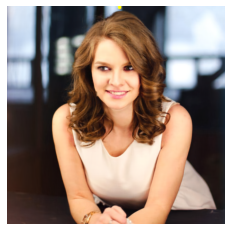

In [25]:
import copy
### reconstruct ###

num_iters = 4000

img_noisy_torch = np_to_torch(img_np).type(dtype)
mask_torch = np_to_torch(img_mask_np).type(dtype)

start = time.time()

mse_wrt_noisy, net  = fit(copy.deepcopy(net).cuda(),
                          img_noisy_torch.type(dtype),
                          net_input = ni,
                          num_iter=num_iters,
                          LR=0.008,
                          mask = mask_torch
                          )


print('\nfinished after %.1f minutes.'%((time.time()-start)/60))

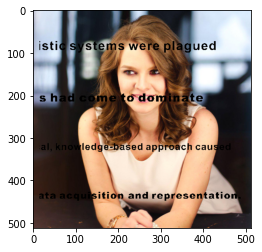

In [32]:
plt.imshow((img_noisy_torch*mask_torch).squeeze(0).permute(1,2,0).data.cpu().numpy())

In [ ]:
del net

In [ ]:
rec = net(ni)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


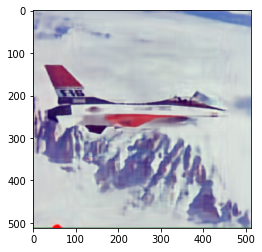

In [ ]:
plt.imshow(rec.squeeze(0).permute(1,2,0).data.cpu().numpy())

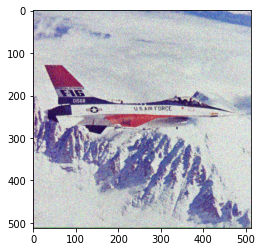

In [ ]:
plt.imshow(img_noisy_np.transpose(1,2,0))

### Download the saved images

In [27]:
!zip CNN_inpainting_img_dir.zip CNN_inpainting_img_dir/*

  adding: CNN_inpainting_img_dir/cnn_generated_iter1000.png (deflated 1%)
  adding: CNN_inpainting_img_dir/cnn_generated_iter1200.png (deflated 1%)
  adding: CNN_inpainting_img_dir/cnn_generated_iter1400.png (deflated 1%)
  adding: CNN_inpainting_img_dir/cnn_generated_iter1600.png (deflated 1%)
  adding: CNN_inpainting_img_dir/cnn_generated_iter1800.png (deflated 1%)
  adding: CNN_inpainting_img_dir/cnn_generated_iter2000.png (deflated 1%)
  adding: CNN_inpainting_img_dir/cnn_generated_iter200.png (deflated 1%)
  adding: CNN_inpainting_img_dir/cnn_generated_iter2200.png (deflated 1%)
  adding: CNN_inpainting_img_dir/cnn_generated_iter2400.png (deflated 1%)
  adding: CNN_inpainting_img_dir/cnn_generated_iter2600.png (deflated 1%)
  adding: CNN_inpainting_img_dir/cnn_generated_iter2800.png (deflated 1%)
  adding: CNN_inpainting_img_dir/cnn_generated_iter3000.png (deflated 1%)
  adding: CNN_inpainting_img_dir/cnn_generated_iter3200.png (deflated 1%)
  adding: CNN_inpainting_img_dir/cnn_ge